### 02 Queries, Take 1

Add more descriptive title and summary later.

In [29]:
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%load_ext sql
%sql sqlite:///nyc_inspections.db

Before diving too deep, let's explore the base tables in the database to see any missing or out of place values.

In [3]:
%%sql
SELECT boro, COUNT(camis) AS n_restaurants FROM restaurants
GROUP BY boro
HAVING boro != '0'
LIMIT 10;

 * sqlite:///nyc_inspections.db
Done.


BORO,n_restaurants
Bronx,19620
Brooklyn,55205
Manhattan,77600
Queens,48972
Staten Island,6664


Unlabeled boroughs were marked as "0". The above query filters them out.

In [3]:
%%sql
SELECT * FROM inspections
ORDER BY INSPECDATE
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


INSPECDATE,INSPECTYPE,CAMIS,SCORE,GRADE,VIOLCODE
1900-01-01 00:00:00,None,50125332,None,None,None
1900-01-01 00:00:00,None,50113608,None,None,None
1900-01-01 00:00:00,None,50132947,None,None,None
1900-01-01 00:00:00,None,50131641,None,None,None
1900-01-01 00:00:00,None,50107034,None,None,None


Dataset documentation says any entries with an inspection date of 1900-01-01 are new restaurants without an inspection yet. These will have to be filtered out in later analyses.

### Total number of restaurants
Let's start by seeing how many total restaurants are in this dataset.

In [2]:
%%sql
SELECT COUNT(DISTINCT camis) AS n_restaurants
FROM inspections;

 * sqlite:///nyc_inspections.db
Done.


n_restaurants
28348


In [5]:
# Save result to workspace
n_restau = _

Next we'll try filtering the results for inspections that resulted in a valid grade. For anything but initial inspections, grades are not given unless the score is <= 13. If a restaurant recieves a score > 13, the grade for that inspection will still be the grade received during the last inspection cycle and is therefore not reflective of their "current" grade.

In [3]:
%%sql
SELECT camis, MAX(inspecdate) AS lastinspection, grade, score, violcode
FROM inspections
WHERE (
      inspectype IN (                                            
            'Cycle Inspection / Re-inspection',
            'Pre-permit (Operational) / Re-inspection'
            )
      OR (inspectype IN (
            'Cycle Inspection / Initial Inspection',                                  
            'Pre-permit (Operational) / Initial Inspection'
            )
            AND SCORE <= 13
            )
      OR (inspectype IN (                                                    
            'Pre-permit (Operational) / Reopening Inspection',
            'Cycle Inspection / Reopening Inspection'
            )))
      AND GRADE IN ('A', 'B', 'C', 'P', 'Z')
GROUP BY camis
LIMIT 10;

 * sqlite:///nyc_inspections.db
Done.


CAMIS,lastinspection,GRADE,SCORE,VIOLCODE
30075445,2023-02-03 00:00:00,Z,13.0,02G
30112340,2022-07-13 00:00:00,A,11.0,10F
30191841,2022-01-04 00:00:00,A,12.0,10F
40356018,2022-02-01 00:00:00,A,7.0,02G
40356483,2022-08-19 00:00:00,A,2.0,10F
40356731,2023-01-17 00:00:00,A,9.0,08A
40357217,2021-07-28 00:00:00,A,10.0,02G
40359480,2022-05-03 00:00:00,A,9.0,06D
40359705,2022-02-10 00:00:00,A,12.0,10F
40360045,2023-01-31 00:00:00,A,13.0,04M


### Valid grades
How many restaurants did *not* have valid grades? To find this we'll count all the restaurants *with* valid grades and subtract that from the total number of restaurants in the dataset.

In [4]:
%%sql
SELECT COUNT(camis) AS n_restaurants
FROM (
      SELECT camis, MAX(inspecdate) AS lastinspection, grade, score
      FROM inspections
      WHERE (
            inspectype IN (                                            
                  'Cycle Inspection / Re-inspection',
                  'Pre-permit (Operational) / Re-inspection'
                  )
            OR (inspectype IN (
                  'Cycle Inspection / Initial Inspection',                                  
                  'Pre-permit (Operational) / Initial Inspection'
                  )
                  AND SCORE <= 13
                  )
            OR (inspectype IN (                                                    
                  'Pre-permit (Operational) / Reopening Inspection',
                  'Cycle Inspection / Reopening Inspection'
                  )))
            AND GRADE IN ('A', 'B', 'C', 'P', 'Z')
      GROUP BY camis
      )

 * sqlite:///nyc_inspections.db
Done.


n_restaurants
22228


In [8]:
n_restau_graded = _

In [9]:
df_restau = n_restau.DataFrame()
df_restau_graded = n_restau_graded.DataFrame()

invalid = int(df_restau.values - df_restau_graded.values)
print(f'{invalid} out of {int(df_restau.values)} restaurants had invalid grades.')

6120 out of 28348 restaurants had invalid grades.


Let's make the query for valid grades into a temporary view to simplify follow-on queries.

In [5]:
%%sql
DROP VIEW IF EXISTS has_grade;

CREATE TEMP VIEW has_grade AS

SELECT camis, MAX(inspecdate) AS lastinspection, grade, score, violcode
FROM inspections
WHERE (
      inspectype IN (                                            
            'Cycle Inspection / Re-inspection',
            'Pre-permit (Operational) / Re-inspection'
            )
      OR (inspectype IN (
            'Cycle Inspection / Initial Inspection',                                  
            'Pre-permit (Operational) / Initial Inspection'
            )
            AND SCORE <= 13
            )
      OR (inspectype IN (                                                    
            'Pre-permit (Operational) / Reopening Inspection',
            'Cycle Inspection / Reopening Inspection'
            )))
      AND GRADE IN ('A', 'B', 'C', 'P', 'Z')
GROUP BY camis;

 * sqlite:///nyc_inspections.db
Done.
Done.


[]

### Borough comparisons
It would be interesting to see how the boroughs compare across restaurants. Let's join the has_grade table with the restaurants table. But first let's verify what's in each table.

In [4]:
%%sql
SELECT * FROM restaurants
GROUP BY camis
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


CAMIS,DBA,CUISDESC,ZIPCODE,BORO,Latitude,Longitude
30075445,MORRIS PARK BAKE SHOP,Bakery Products/Desserts,10462,Bronx,40.848231224526,-73.855971889932
30112340,WENDY'S,Hamburgers,11225,Brooklyn,40.662651518808,-73.962081374927
30191841,DJ REYNOLDS PUB AND RESTAURANT,Irish,10019,Manhattan,40.767325711553,-73.984310423617
40356018,RIVIERA CATERERS,American,11224,Brooklyn,40.579920366974,-73.98209024916
40356483,WILKEN'S FINE FOOD,Sandwiches,11234,Brooklyn,40.620111590927,-73.906989489698


In [5]:
%%sql
SELECT * FROM has_grade
GROUP BY camis
LIMIT 5;


 * sqlite:///nyc_inspections.db
Done.


CAMIS,lastinspection,GRADE,SCORE,VIOLCODE
30075445,2023-02-03 00:00:00,Z,13.0,02G
30112340,2022-07-13 00:00:00,A,11.0,10F
30191841,2022-01-04 00:00:00,A,12.0,10F
40356018,2022-02-01 00:00:00,A,7.0,02G
40356483,2022-08-19 00:00:00,A,2.0,10F


Now let's join the two tables to combine the business name, cuisine type, and borough fields with the grade and score info.

In [6]:
%%sql
SELECT has_grade.camis, dba, cuisdesc, grade, 
    score, boro
FROM has_grade
JOIN restaurants
ON has_grade.camis = restaurants.camis
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


CAMIS,DBA,CUISDESC,GRADE,SCORE,BORO
50072080,SIMON & THE WHALE,American,A,7.0,Manhattan
40825908,POLANCO RESTAURANT BBQ,Latin American,A,10.0,Manhattan
50040406,DOUGH,Donuts,A,12.0,Manhattan
50012650,LOS POBLANOS RESTAURANT,Mexican,Z,39.0,Brooklyn
50015482,WING HING CHINESE CUISINE,Chinese,A,7.0,Brooklyn


How many restaurants are in the table now?

In [35]:
%%sql
SELECT COUNT(camis) AS n_restaurants FROM (
    SELECT has_grade.camis, dba, grade, 
        score, boro
    FROM has_grade
    JOIN restaurants
    ON has_grade.camis = restaurants.camis
)
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


n_restaurants
194684


**Note:** Using `DISTINCT camis` would be more correct like in the query below. However, adding `DISTINCT` causes the query compute time to go from 0.1 seconds to 3+ minutes for some reason on my machine.

In [8]:
%%sql
SELECT COUNT(DISTINCT camis) AS n_restaurants FROM (
    SELECT has_grade.camis, dba, grade, 
        score, boro
    FROM has_grade
    JOIN restaurants
    ON has_grade.camis = restaurants.camis
)
LIMIT 5;

 * sqlite:///nyc_inspections.db


### Borough grades
How do the boroughs compare in terms of grades? We'll group by grade and borough and quickly plot the results.

In [7]:
%%sql by_grade <<
SELECT grade, boro, 
    COUNT(has_grade.camis) AS n_restaurants
FROM has_grade
JOIN restaurants
ON has_grade.camis = restaurants.camis
GROUP BY grade, boro
HAVING boro != 0
LIMIT 50;

 * sqlite:///nyc_inspections.db
Done.
Returning data to local variable by_grade


In [34]:
# Convert to dataframe
df_grade = by_grade.DataFrame()
df_grade.head(8)

,GRADE,BORO,n_restaurants
0,A,Bronx,13313
1,A,Brooklyn,36843
2,A,Manhattan,54650
3,A,Queens,32871
4,A,Staten Island,4891
5,B,Bronx,2023
6,B,Brooklyn,5005
7,B,Manhattan,6389


Text(0, 0.5, '# of Restaurants')

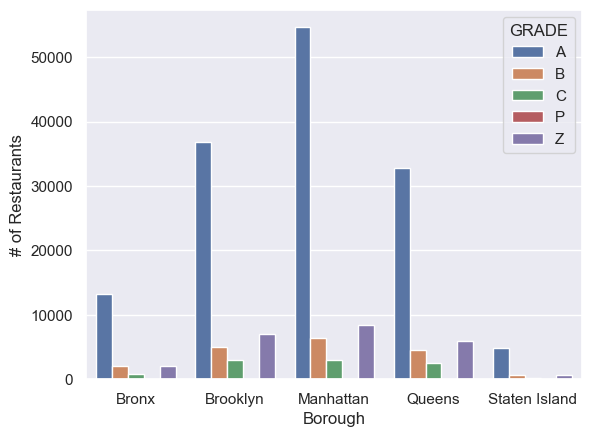

In [33]:
# Plot
sns.barplot(data=df_grade, x='BORO', y='n_restaurants', hue='GRADE')
plt.xlabel('Borough')
plt.ylabel('# of Restaurants')

To normalize the results, we can divide the number of restaurants for a given grade by the total number of restaurants per borough.

In [40]:
df_totals = df_grade.groupby(by='BORO').sum('n_restaurants')
df_totals.head(8)

,n_restaurants
BORO,
Bronx,18089
Brooklyn,51866
Manhattan,72498
Queens,45922
Staten Island,6270


In [39]:
df_totals = df_totals.merge(df_grade_A[['BORO', 'n_restaurants']], on='BORO', how='inner',
                            suffixes=('_total', '_A'))

df_grade_A = df_grade.query("GRADE == 'A'")
df_totals['grade_A'] = df_totals['n_restaurants_A'] / df_totals['n_restaurants_total']

df_totals.sort_values(by='grade_A').head()

,BORO,n_restaurants_total,n_restaurants_A,grade_A
1,Brooklyn,51866,36843,0.710350
3,Queens,45922,32871,0.715801
0,Bronx,18089,13313,0.735972
2,Manhattan,72498,54650,0.753814
4,Staten Island,6270,4891,0.780064


### Borough cuisines
Which cuisines are more common in each borough? We'll start by looking at how many unique cuisines there are.

In [43]:
%%sql
SELECT COUNT(DISTINCT cuisdesc)
FROM restaurants
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


COUNT(DISTINCT cuisdesc)
87


That's a lot of different cuisines. Let's limit our analysis to the top 5 in each borough. We'll also limit the results to grade A restaurants. To do this we'll have to join the `restaurants` and `has_grade` tables again.

In [46]:
%%sql
SELECT * FROM restaurants
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


CAMIS,DBA,CUISDESC,ZIPCODE,BORO,Latitude,Longitude
50125332,None,None,11103,Queens,40.766568442385,-73.905123532108
50113608,BIRDIES HOT CHICKEN,None,11211,Brooklyn,40.71190313079,-73.941113998372
50132947,None,None,11235,Brooklyn,40.584915043468,-73.951033402941
50131641,None,None,11385,Queens,40.700198634374,-73.90680880349
50107034,POPYE'S,None,11691,Queens,40.596422966153,-73.754162918486


In [47]:
%%sql
SELECT * FROM has_grade
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


CAMIS,lastinspection,GRADE,SCORE,VIOLCODE
30075445,2023-02-03 00:00:00,Z,13.0,02G
30112340,2022-07-13 00:00:00,A,11.0,10F
30191841,2022-01-04 00:00:00,A,12.0,10F
40356018,2022-02-01 00:00:00,A,7.0,02G
40356483,2022-08-19 00:00:00,A,2.0,10F


In [54]:
%%sql
SELECT DISTINCT has_grade.camis, boro, cuisdesc, grade
FROM restaurants
JOIN has_grade
ON restaurants.camis == has_grade.camis
WHERE grade = 'A'
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


CAMIS,BORO,CUISDESC,GRADE
30112340,Brooklyn,Hamburgers,A
30191841,Manhattan,Irish,A
40356018,Brooklyn,American,A
40356483,Brooklyn,Sandwiches,A
40356731,Brooklyn,Frozen Desserts,A


In [57]:
%%sql
SELECT DISTINCT has_grade.camis, boro, cuisdesc, grade
FROM restaurants
JOIN has_grade
ON restaurants.camis == has_grade.camis
WHERE grade = 'A' AND boro != 0
GROUP BY boro, cuisdesc
LIMIT 5;

 * sqlite:///nyc_inspections.db
Done.


CAMIS,BORO,CUISDESC,GRADE
40368026,Bronx,African,A
40357217,Bronx,American,A
50039683,Bronx,Asian/Asian Fusion,A
50063156,Bronx,Bagels/Pretzels,A
40394761,Bronx,Bakery Products/Desserts,A


In [58]:
# TODO: use CTE to aggregate by borough and cuisine to get restaurant # sums